# Comparision among Hippocampus pixel classifiers  for 7-D feature vector

## Load libraries

In [1]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import SGDClassifier
from scipy.stats import expon, reciprocal

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import numpy as np
import pandas as pd

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from joblib import dump, load

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MSE

from rbflayer import RBFLayer, InitCentersRandom
from kmeans_initializer import InitCentersKMeans
from initializer import InitFromFile

## Load dataset

In [4]:


testDataset = pd.read_csv('../data/testDatasetValues_R35.csv', index_col=0)
testLabels = pd.read_csv('../data/testDatasetLabels_R35.csv', index_col=0).values.ravel()
testLabels[testLabels>1]=1

print("testDataset.shape\n", testDataset.values[:,3:10].shape)
print("")
print("testLabels.shape\n", testLabels.shape)
print("")

X_val = testDataset.values
y_val = testLabels

testDataset.shape
 (4906, 7)

testLabels.shape
 (4906,)



## Load StandarScaler and normalize -transform- data with learned meand and std dev

In [5]:
scaler = load('../savedModels/scaler_35_7D.joblib')
X_values = X_val[:,3:10]
X_values = scaler.transform(X_values)

## Helper functions

### helper function for plotting model's roc_cure

In [6]:
markers = [".",",","o","v","^","<",">"]
m = 0
def plot_roc_curve(fpr, tpr, label=None):
    global m
    plt.plot(fpr, tpr, linewidth=1, label=label) #,  marker=markers[m], markevery=50+(m+1))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    m += 1

### helper function for calculating model's metrics

In [7]:
def get_stats(model, title=""):
    print(model)
    
    if hasattr(model, 'decision_function') : 
        y_hat = cross_val_predict(model, X_values, y_val, cv=3, method="decision_function")
    elif hasattr(model, 'get_params') :
        y_hat = cross_val_predict(model, X_values, y_val, cv=3, method="predict_proba")
        y_hat = y_hat[:, 1] # score = proba of positive class
    else :
        model.summary()
        X_v = np.asarray(X_values).astype(np.float32)
        y_hat = model.predict(X_v)
        model.evaluate(X_values,  y_val, verbose=1)
        
    
    au = roc_auc_score(y_val, y_hat)
    fpr, tpr, thresholds = roc_curve(y_val, y_hat)
    plot_roc_curve(fpr, tpr, title + " {:.4f}".format(au))
    
        
    
    y_hat = model.predict(X_values)
    y_hat[y_hat>=0.5] = 1 # make sure only binary data
    y_hat[y_hat<0.5] = 0  # gets evaluated
    
    ac = accuracy_score(y_val, y_hat)
    ps = precision_score(y_val, y_hat)
    rs = recall_score(y_val, y_hat)
    f1 = f1_score(y_val, y_hat)
    cm = confusion_matrix(y_val, y_hat)
    
    return [ac, au, f1, ps, rs, cm]

## Load models

In [8]:
forest_clf = load('../savedModels/forest_clf_35_7D.joblib') 
lsvm_clf = load('../savedModels/lsvm_clf_35_7D.joblib') 
polynomial_svm_clf = load('../savedModels/polynomial_svm_clf_35_7D.joblib')
polK_svm_clf = load('../savedModels/polK_svm_clf_35_7D.joblib') 
grbf_svm_clf = load('../savedModels/grbf_svm_clf_35_7D.joblib') 
mlp = keras.models.load_model('../savedModels/MLP_R35_7D.h5')
nn_rbf = load_model('../savedModels/RBFN_R35_7D.h5', custom_objects={'RBFLayer': RBFLayer})

## Fetch metrics and plot roc curve

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
LinearSVC(C=182, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=8900,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('svm_clf',
                 LinearSVC(C=681, class_weight=None, dual=False,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=42,
                           tol=0.0001, verbose=0))],
         verbose=False)
SVC(C=2.1, break_ties=False, cache_size=200, class_weight=None, coef0=40,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
SVC(C=55, break_ties=False, cache_size=200, class_weight=None, coef0=908,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=Fa

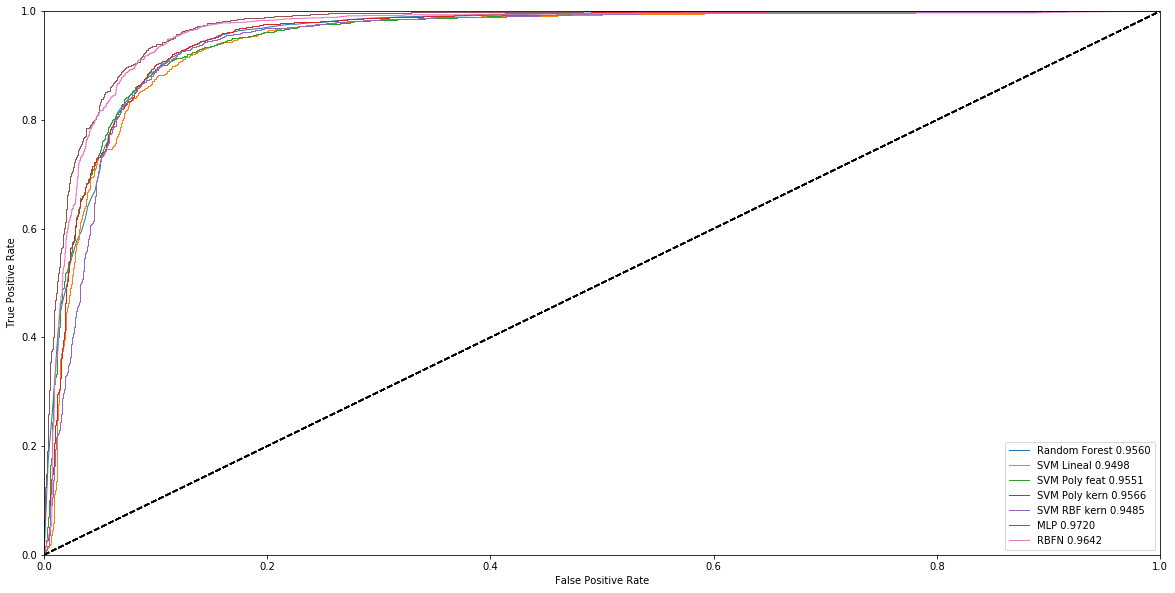

In [9]:
plt.figure(figsize=(20,10))

stats = []

stats.append(get_stats(forest_clf, "Random Forest"))
stats.append(get_stats(lsvm_clf, "SVM Lineal"))
stats.append(get_stats(polynomial_svm_clf, "SVM Poly feat"))
stats.append(get_stats(polK_svm_clf, "SVM Poly kern"))
stats.append(get_stats(grbf_svm_clf, "SVM RBF kern"))
stats.append(get_stats(mlp, "MLP"))
stats.append(get_stats(nn_rbf, "RBFN"))

### Print metrics

In [10]:
stats = np.array(stats)

models = pd.DataFrame({'Model': ["Random Forest", "SVM Lineal", "SVM Poly feat", "SVM Poly kern", "SVM RBF kern", "MLP", "RBFN"]}) #
metrics = pd.DataFrame(data=stats[:,:-1], columns=["Accuracy", "AUC", "F1", "Precision Score", "Recall Score"])

models = pd.concat([models, metrics], axis=1).sort_values(by=["Model"],ascending=True)
models

,Model,Accuracy,AUC,F1,Precision Score,Recall Score
5,MLP,0.917652,0.972026,0.919905,0.895753,0.945395
6,RBFN,0.915206,0.964216,0.917098,0.897426,0.937653
0,Random Forest,0.915614,0.955985,0.917661,0.89627,0.940098
1,SVM Lineal,0.899715,0.949849,0.901992,0.882307,0.922575
2,SVM Poly feat,0.907868,0.955057,0.910918,0.882061,0.941728
3,SVM Poly kern,0.912556,0.95663,0.914729,0.892899,0.937653
4,SVM RBF kern,0.917856,0.948544,0.920591,0.891263,0.951915
